In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import warnings
import tensorflow as tf
from tensorflow.python.ops import nn


py_file_location = "..."
os.path.abspath(os.path.join(os.path.dirname(py_file_location), os.path.pardir))

from model_DL import *
from functions import *
from metrics import *
from DNN_metrics import *
from data_generator import *
from loss_function import *
from optimization import *



#tf.device('GPU:0') 

2022-03-10 00:02:46.575848: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
root_dir ='DNN'
tau=0.25
model = tf.keras.models.load_model(root_dir+'/lambda = 10_0.5/weights/10_0.5.h5', custom_objects={'DF_loss':loss_DF(Lambda,tau),'Primary_Achievable_Rate_Degradation':Primary_Achievable_Rate_Degradation,'Primary_ARDP':Primary_ARD_Percentage,'throughput':Achievable_Rate(tau),'V_Qos':QoS_Violation(tau), "custom_sigmoid":custom_sigmoid})


2022-03-10 00:02:47.998507: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-03-10 00:02:48.000036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-03-10 00:02:48.068600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-03-10 00:02:48.069004: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 1 with properties: 
pciBusID: 0000:5e:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.62GHz coreCount: 72 deviceMemorySize: 44.49GiB deviceMemoryBandwidth: 581.23GiB/s
2022-03-10 00:02:48.069036: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2022-03-10 00:0

In [3]:
def pdd(Grp, Gpp, Gsp, Alpha, Pr, Ps):
    """
      Parameters:
         Grp: 1D Array containing Alpha values.
         Gpp: 1D Array containing Gain between primary transmitter and primary receiver.
         Gsp: 1D Array containing Gain between secondary transmitter and primary receiver.
         Alpha: 1D Array containing Alpha values.
         Pr: 1D Array containing Power of relay.
         Ps: 1D Array containing Power of secondary network.
      
      Returns:
         primary debit degradation .

    """

    Rp = C((Gpp*Pp)/(Grp*Pr**2+Gsp*Ps**2+2*(np.sqrt(Gsp*Grp)*Ps*Pr*Alpha)+1))
    Rp_max = C(Gpp*Pp)
    ratio_Rp = np.nan_to_num((Rp_max-Rp)/Rp_max)
    return ratio_Rp

def channel_gain_with_gaussian_fading_G(d, sigma=7, alpha=3):  # channel gain model
    s = np.random.normal(0.0, sigma, d.shape)
    h = s/np.sqrt(1+np.power(d, alpha))
    g = h**2
    return g

In [4]:
# # choose your directory path  
project_sub_path = "Relay_Plot"
  
# Parent Directory path
parent_dir = ""
  
# Path
try : 

    path = os.path.join(parent_dir, project_sub_path)
    os.mkdir(path)
    print("Directory '% s' created" % project_sub_path)
except FileExistsError : 
    pass

In [14]:
n = 256
sampling = 10000
step_sampling = 100
Pp = 10
p_min = 0
p_max = 10
x_min, x_max = p_min, p_max
y_min, y_max = p_min, p_max

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_1 = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_1 = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_2 = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10
D_2 = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

d_11 = np.linalg.norm(U_1 - D_1, axis=1)
d_12 = np.linalg.norm(U_1 - D_2, axis=1)
d_1R = np.linalg.norm(U_1 - R  , axis=1)
d_21 = np.linalg.norm(U_2 - D_1, axis=1)
d_22 = np.linalg.norm(U_2 - D_2, axis=1)
d_2R = np.linalg.norm(U_2 - R  , axis=1)
d_R1 = np.linalg.norm(R   - D_1, axis=1)
d_R2 = np.linalg.norm(R   - D_2, axis=1)

#d_11, d_12, d_1R, d_21, d_22, d_2R, , d_R2
D_test_R = np.c_[d_R1, d_11, d_2R, d_1R, d_22, d_R2, d_21, d_12].astype(np.float32)

#D_test_R = np.c_[d_11, d_12, d_1R, d_21, d_22, d_2R, d_R1, d_R2].astype(np.float32)



P_R_mean = np.zeros(Rxx.shape)
P_S_mean = np.zeros(Rxx.shape)
aplha_mean = np.zeros(Rxx.shape)
D_mean = np.zeros(Rxx.shape)
S_mean = np.zeros(Rxx.shape)
pr_np = 'Relay_Plot/P_R_mean2'
ps_np = 'Relay_Plot/P_S_mean2'
alpha_np = 'Relay_Plot/alpha_mean2'
D_np = 'Relay_Plot/D_mean2'
S_np = 'Relay_Plot/S_mean2'

for i in range(int(sampling/step_sampling)):
    print(i)
    
    G = channel_gain_with_gaussian_fading_G((D_test_R[None,:,:]*np.ones((step_sampling,1,1))).reshape(-1,8), 7)
    Y = model.predict(G, batch_size = 4096)
    D = pdd(G[:,0], G[:,1], G[:,6], Y[:,0], Y[:,1], Y[:,2])
    S = rate(G[:,0], G[:,1], G[:,2], G[:,3], G[:,4], G[:,5], G[:,6], G[:,7], Y[:,0], Y[:,1], Y[:,2]) 
    S = S[:,8]
    del G
    alpha = Y[:,0]
    P_R = np.power(Y[:,1], 2)
    P_S = np.power(Y[:,2], 2)

    del Y
    P_R_mean = P_R_mean + np.sum(P_R.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    P_S_mean = P_S_mean + np.sum(P_S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    aplha_mean = aplha_mean + np.sum(alpha.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    D_mean = D_mean + np.sum(D.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)
    S_mean = S_mean + np.sum(S.reshape((step_sampling,-1)),axis=0).reshape(Rxx.shape)   

    np.savez(pr_np, P_R_mean)
    np.savez(ps_np, P_S_mean)
    np.savez(alpha_np, aplha_mean)
    np.savez(D_np, D_mean)
    np.savez(S_np, S_mean)


P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling
D_mean = D_mean/sampling
S_mean = S_mean/sampling

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40


/tmp/ipykernel_76760/2157744698.py:18: RuntimeWarning: invalid value encountered in true_divide
  ratio_Rp = np.nan_to_num((Rp_max-Rp)/Rp_max)


41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [5]:
p_min = 0
p_max = 10


P_R_mean = np.load('Relay_Plot/P_R_mean2.npz')
P_S_mean = np.load('Relay_Plot/P_S_mean2.npz')
aplha_mean = np.load('Relay_Plot/alpha_mean2.npz')
D_mean = np.load('Relay_Plot/D_mean2.npz')
S_mean = np.load('Relay_Plot/S_mean2.npz')

P_R_mean.files
P_R_mean = P_R_mean['arr_0']

P_S_mean.files
P_S_mean = P_S_mean['arr_0']

aplha_mean.files
aplha_mean = aplha_mean['arr_0']

D_mean.files
D_mean = D_mean['arr_0']
S_mean.files
S_mean = S_mean['arr_0']

n = 256
sampling = 10000
step_sampling = 100
x_min, x_max = p_min, 10
y_min, y_max = p_min, 10

Rxx, Ryy = np.meshgrid(np.linspace(x_min, x_max, n),
                     np.linspace(y_min, y_max, n))

R = np.c_[Rxx.ravel(), Ryy.ravel()]


U_1 = np.ones((R.shape[0],2)) * np.array([0.25, 0.5])*10
D_1 = np.ones((R.shape[0],2)) * np.array([0.5, 0.75])*10
U_2 = np.ones((R.shape[0],2)) * np.array([0.5, 0.25])*10

D_2 = np.ones((R.shape[0],2)) * np.array([0.75, 0.5])*10

In [6]:
P_R_mean = P_R_mean/sampling
P_S_mean = P_S_mean/sampling
aplha_mean = aplha_mean/sampling
D_mean = D_mean/sampling
S_mean = S_mean/sampling

### Average predicted relay power

/tmp/ipykernel_79932/84618018.py:11: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),5), shrink=1, cmap = 'viridis')


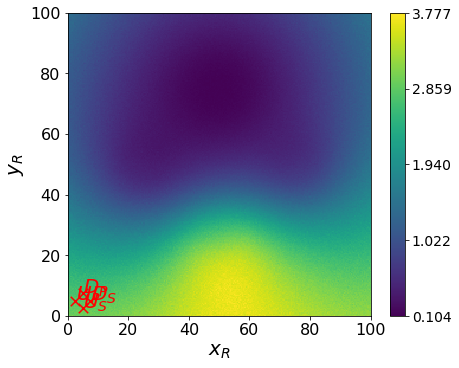

In [7]:
pos_min = p_min*10
pos_max = p_max*10

plt.figure(figsize=(6,4.8))
ax = plt.gca()
plt.tight_layout()
D_mean = D_mean*100

cax = ax.matshow(P_R_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(P_R_mean),np.max(P_R_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red', s=90)
        plt.annotate(l, (v[0]+0.2, v[1]), c='red', fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)

plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 


plt.savefig('P_R.pdf', dpi=300, bbox_inches='tight')

### Average primary rate degradation

/tmp/ipykernel_79932/3029651350.py:10: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  plt.colorbar(cax, ticks=np.linspace(np.min(D_mean),np.max(D_mean),5), shrink=1, cmap = 'viridis')


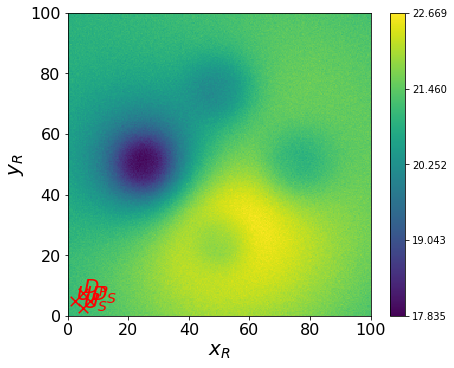

In [12]:
pos_min = p_min*10
pos_max = p_max*10
plt.figure(figsize=(6,4.8))
ax = plt.gca()
plt.tight_layout()

#D_mean = D_mean*100
cax = ax.matshow(D_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
plt.colorbar(cax, ticks=np.linspace(np.min(D_mean),np.max(D_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)

        plt.scatter(v[0], v[1], marker="x", c='red', s=90)
        plt.annotate(l, (v[0]+0.2, v[1]), c='red', fontsize=20)
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('D_Mean.pdf', dpi=300, bbox_inches='tight')

### Average secondary rate

/tmp/ipykernel_79932/3321826631.py:10: MatplotlibDeprecationWarning: The 'cmap' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')


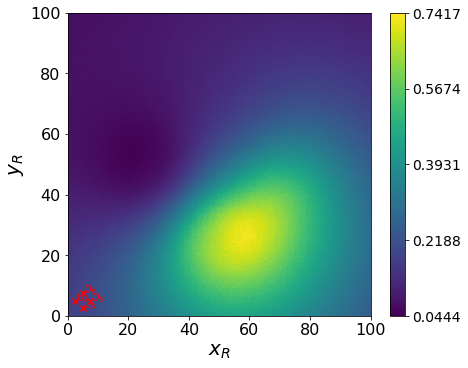

In [11]:
pos_min = p_min*10
pos_max = p_max*10
#sns.set(font_scale=5) 
plt.figure(figsize=(6,4.8))

ax = plt.gca()
plt.tight_layout()
cax = ax.matshow(S_mean, origin='lower', extent=[pos_min, pos_max, pos_min, pos_max],cmap = 'viridis')
ax.xaxis.set_ticks_position('bottom')
cbar = plt.colorbar(cax, ticks=np.linspace(np.min(S_mean),np.max(S_mean),5), shrink=1, cmap = 'viridis')
for v, l in ((U_1[0,:], "$U_P$"), (U_2[0,:], "$U_S$"), (D_1[0,:], "$D_P$"), (D_2[0,:], "$D_S$")):
        plt.grid(False)
        plt.scatter(v[0], v[1], marker="x", c='red')
        plt.annotate(l, (v[0]+0.2, v[1]), c='red')
        
for t in cbar.ax.get_yticklabels():
     t.set_fontsize(14)

plt.xlabel('$x_R$', fontsize=20)
plt.ylabel('$y_R$', fontsize=20)
plt.xticks(fontsize=16) 
plt.yticks(fontsize=16) 

plt.savefig('S_Mean.pdf', dpi=300, bbox_inches='tight')